In [1]:
pip install emoji


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 7.6 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
import os
import regex as re  # Note: Using the 'regex' library for enhanced regex capabilities
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import emoji
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report
)
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments
)
import torch


In [3]:
def load_combined_chat(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        chat = file.read()
    return chat


In [4]:
# Regex pattern to match WhatsApp messages
pattern = r'''
    ^                               # Start of a line
    (?P<Date>\d{1,2}[\/\-]\d{1,2}[\/\-]\d{2,4}),?\s+   # Date
    (?P<Time>\d{1,2}:\d{2}(?::\d{2})?\s?(?:AM|PM|am|pm)?) -   # Time
    (?:(?P<Sender>[^:]+):\s)?       # Sender
    (?P<Message>.+)?                # Message
    $
'''


In [5]:
def preprocess_chat(chat):
    # Split the chat into lines
    lines = chat.split('\n')
    data = []
    message_buffer = ''
    date = time = sender = None
    for line in lines:
        # Trying to match the line with the regex pattern
        match = re.match(pattern, line, re.VERBOSE)
        if match:
            # If there's a previous message, append it
            if message_buffer:
                data.append([date, time, sender, message_buffer.strip()])
                message_buffer = ''
            date = match.group('Date')
            time = match.group('Time')
            sender = match.group('Sender')
            message = match.group('Message')
            if message:
                message_buffer = message
            else:
                message_buffer = ''
        else:
            # If the line doesn't match, it's a continuation of the previous message
            message_buffer += '\n' + line
    # Adding the last message
    if message_buffer:
        data.append([date, time, sender, message_buffer.strip()])
    df = pd.DataFrame(data, columns=['Date', 'Time', 'Sender', 'Message'])
    return df


In [6]:
# Load the combined chat data
chat = load_combined_chat('/content/enhanced_whatsapp_chat_with_1000.txt')

# Preprocess the chat data
df = preprocess_chat(chat)


In [7]:
print(df.head())


         Date    Time  Sender  \
0        None    None    None   
1  01/01/2024  15:56     Emma   
2  03/01/2024  15:34     Alex   
3  05/01/2024  15:16    Sarah   
4  06/01/2024  22:43     Alex   

                                             Message  
0  26/01/2020, 4:19 pm - Messages and calls are e...  
1  Can we prioritize a funny meme in tomorrow's s...  
2  Have you seen the latest trends in a technical...  
3  Can we prioritize weekend plans in tomorrow's ...  
4  Hey Daniel, have you seen this about an upcomi...  


In [8]:
# Removing the system messages (entries without a sender)
df = df.dropna(subset=['Sender'])


In [9]:
df.reset_index(drop=True, inplace=True)


In [10]:
# Convert Date and Time to datetime objects
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], errors='coerce')

# Drop rows with invalid DateTime
df = df.dropna(subset=['DateTime'])

# Extract date and time components
df['Date'] = df['DateTime'].dt.date
df['TimeOnly'] = df['DateTime'].dt.time
df['Hour'] = df['DateTime'].dt.hour
df['Minute'] = df['DateTime'].dt.minute
df['DayName'] = df['DateTime'].dt.day_name()
df['Month'] = df['DateTime'].dt.month_name()
df['Year'] = df['DateTime'].dt.year


Total messages in the chat: 1000


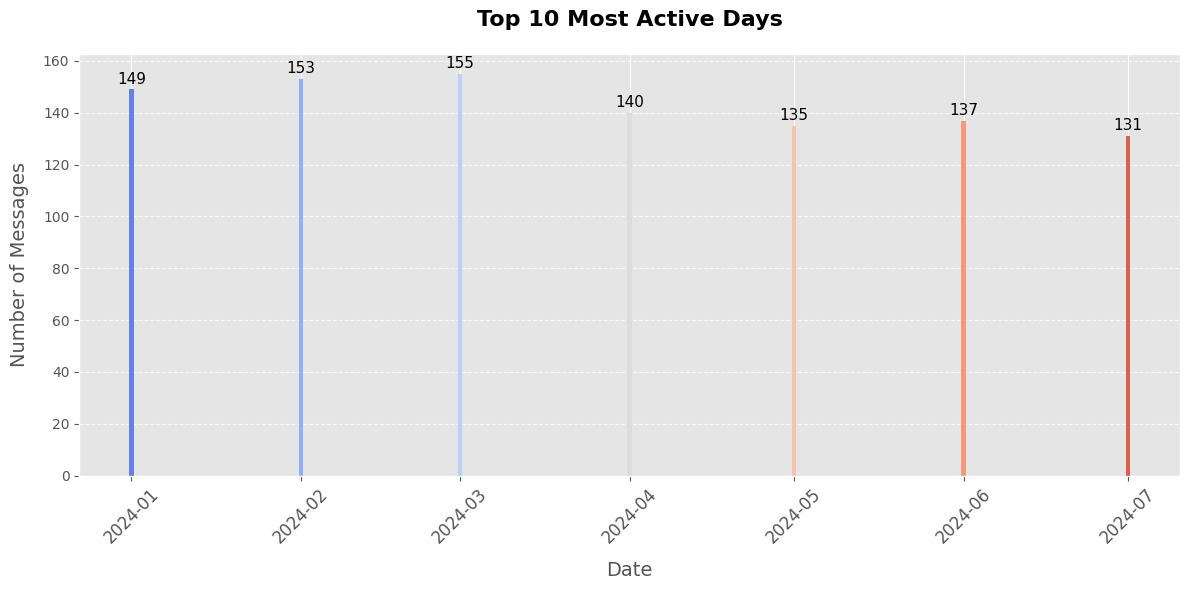

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate total messages
total_messages = df.shape[0]
print(f"Total messages in the chat: {total_messages}")

# Calculate top 10 most active days
messages_per_day = df['Date'].value_counts().head(10).sort_index()

# Set the style for the plot
plt.style.use('ggplot')

# Create a color palette
colors = sns.color_palette("coolwarm", len(messages_per_day))

# Plot the data
plt.figure(figsize=(12, 6))
bars = plt.bar(messages_per_day.index, messages_per_day.values, color=colors)

# Add titles and labels
plt.title('Top 10 Most Active Days', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=14, labelpad=10)
plt.ylabel('Number of Messages', fontsize=14, labelpad=10)
plt.xticks(rotation=45, fontsize=12)

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate the bars with exact values
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,
        str(bar.get_height()),
        ha='center',
        va='bottom',
        fontsize=11,
        color='black'
    )

plt.tight_layout()

plt.show()


Top 10 Active Users:
Sender
Daniel    177
Emma      169
Alex      169
John      166
Sarah     162
Priya     157
Name: count, dtype: int64


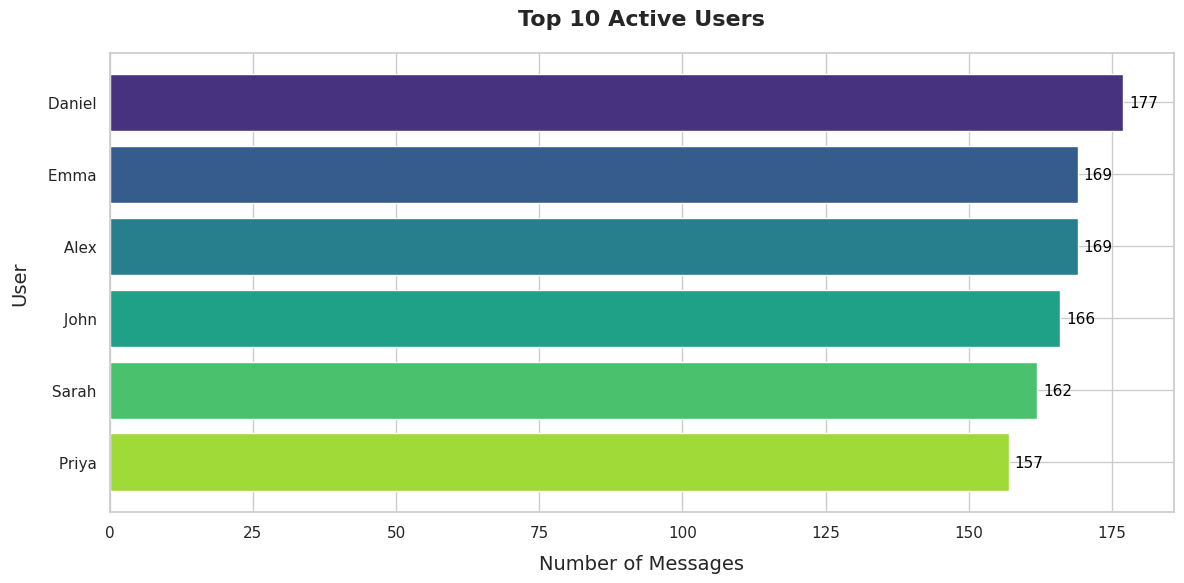

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate top 10 active users
messages_per_user = df['Sender'].value_counts()
top_active_users = messages_per_user.head(10)

# Printing the top 10 active users
print("Top 10 Active Users:")
print(top_active_users)

# Set the style for the plot
sns.set_theme(style="whitegrid")

# Creating a color palette
colors = sns.color_palette("viridis", len(top_active_users))

# Plot the data as a horizontal bar chart
plt.figure(figsize=(12, 6))
bars = plt.barh(top_active_users.index, top_active_users.values, color=colors)

# Add titles and labels
plt.title('Top 10 Active Users', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Number of Messages', fontsize=14, labelpad=10)
plt.ylabel('User', fontsize=14, labelpad=10)

# Invert the y-axis to show the highest values at the top
plt.gca().invert_yaxis()

# Annotate the bars with exact values
for bar in bars:
    plt.text(
        bar.get_width() + 1,
        bar.get_y() + bar.get_height() / 2,
        str(bar.get_width()),
        ha='left',
        va='center',
        fontsize=11,
        color='black'
    )

plt.tight_layout()

plt.show()


In [13]:
all_participants = set(df['Sender'].unique())
active_users = set(df['Sender'].unique())
ghosts = all_participants - active_users
print("Ghosts (Users who have never sent a message):")
print(ghosts)


Ghosts (Users who have never sent a message):
set()


In [14]:
# 4. Top 10 users who sent the most media
media_messages = df[df['Message'] == '<Media omitted>']

# Check if media_messages is empty before proceeding
if media_messages.empty:
    print("No media messages found in the chat.")
else:
    media_per_user = media_messages['Sender'].value_counts().head(10)
    print("Top 10 Users Who Sent the Most Media:")
    print(media_per_user)
    plt.figure(figsize=(12, 6))
    media_per_user.plot(kind='bar', color='orange')
    plt.title('Top 10 Users Who Sent the Most Media')
    plt.xlabel('User')
    plt.ylabel('Number of Media Messages')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

No media messages found in the chat.


Top 10 Most Used Emojis:
  Emoji  Count
0     🙂     13
1     😂     12
2     😭     12
3     🤔     10
4     👌     10
5     🙄      9
6     👍      9
7     ❤      8
8     😅      4


<ipython-input-15-df3f258454d3>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(data=emoji_df, x='Emoji', y='Count', palette=colors)
<ipython-input-15-df3f258454d3>:51: UserWarning: Glyph 128578 (\N{SLIGHTLY SMILING FACE}) missing from current font.
  plt.tight_layout()
<ipython-input-15-df3f258454d3>:51: UserWarning: Glyph 129300 (\N{THINKING FACE}) missing from current font.
  plt.tight_layout()
<ipython-input-15-df3f258454d3>:51: UserWarning: Glyph 128076 (\N{OK HAND SIGN}) missing from current font.
  plt.tight_layout()
<ipython-input-15-df3f258454d3>:51: UserWarning: Glyph 128580 (\N{FACE WITH ROLLING EYES}) missing from current font.
  plt.tight_layout()
<ipython-input-15-df3f258454d3>:51: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/

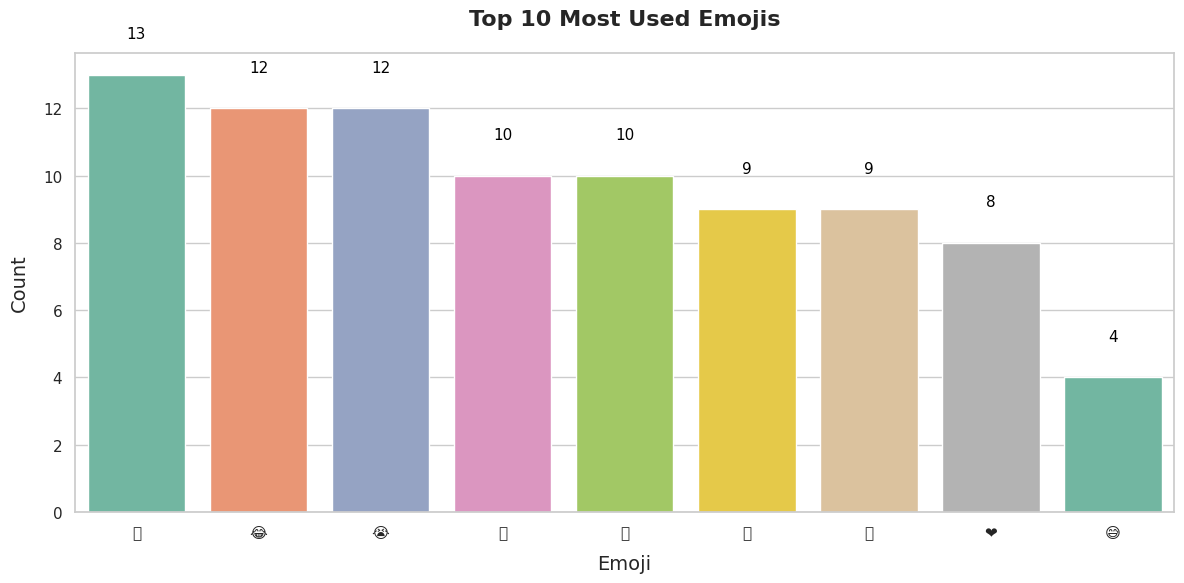

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import emoji

# Function to extract emojis
def extract_emojis(s):
    return ''.join(c for c in s if c in emoji.EMOJI_DATA)

# Extract emojis from the messages
df['Emojis'] = df['Message'].apply(extract_emojis)

# Count all emojis
all_emojis = ''.join(df['Emojis'])
emoji_counter = Counter(all_emojis)

# Get the top 10 most used emojis
top_emojis = emoji_counter.most_common(10)
emoji_df = pd.DataFrame(top_emojis, columns=['Emoji', 'Count'])

# Print the top 10 emojis
print("Top 10 Most Used Emojis:")
print(emoji_df)

# Set the style for the plot
sns.set_theme(style="whitegrid")

# Create the plot
plt.figure(figsize=(12, 6))
colors = sns.color_palette("Set2", len(emoji_df))
bars = sns.barplot(data=emoji_df, x='Emoji', y='Count', palette=colors)

# Add titles and labels
plt.title('Top 10 Most Used Emojis', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Emoji', fontsize=14, labelpad=10)
plt.ylabel('Count', fontsize=14, labelpad=10)

# Annotate the bars with exact counts
for bar, count in zip(bars.patches, emoji_df['Count']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,
        str(count),
        ha='center',
        va='bottom',
        fontsize=11,
        color='black'
    )

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


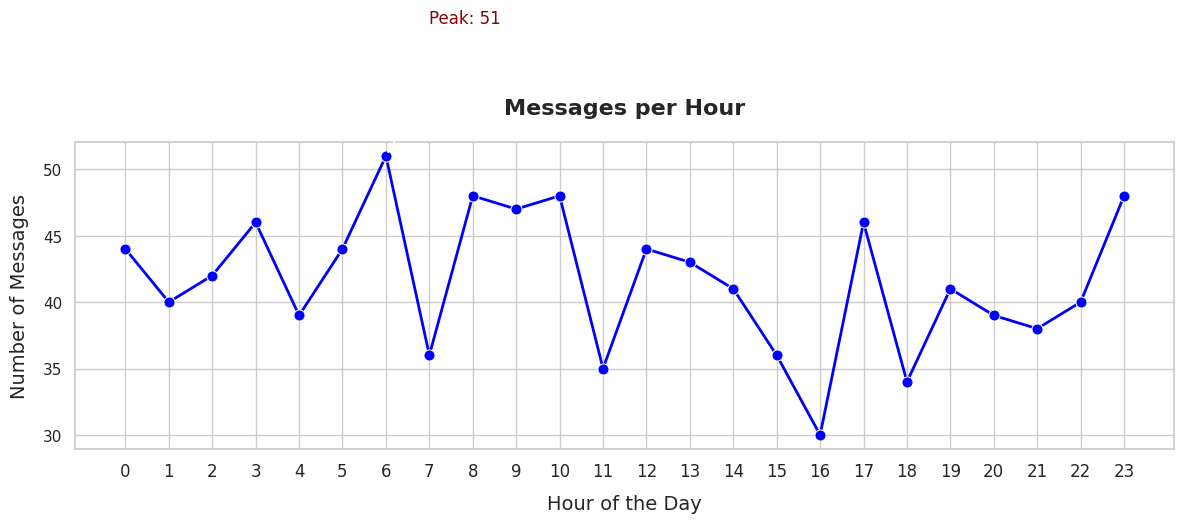

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Messages per hour
messages_per_hour = df['Hour'].value_counts().sort_index()

# Set the style for the plot
sns.set_theme(style="whitegrid")

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    x=messages_per_hour.index,
    y=messages_per_hour.values,
    marker='o',
    linewidth=2,
    color='blue',
    markersize=8
)

# Add titles and labels
plt.title('Messages per Hour', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Hour of the Day', fontsize=14, labelpad=10)
plt.ylabel('Number of Messages', fontsize=14, labelpad=10)

# Highlight the peak hour
peak_hour = messages_per_hour.idxmax()
peak_value = messages_per_hour.max()
plt.annotate(
    f'Peak: {peak_value}',
    xy=(peak_hour, peak_value),
    xytext=(peak_hour + 1, peak_value + 10),
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=12,
    color='darkred'
)

# Adjusting the layout and show the plot
plt.xticks(range(0, 24), fontsize=12)  # Ensure all hours are shown
plt.tight_layout()
plt.show()


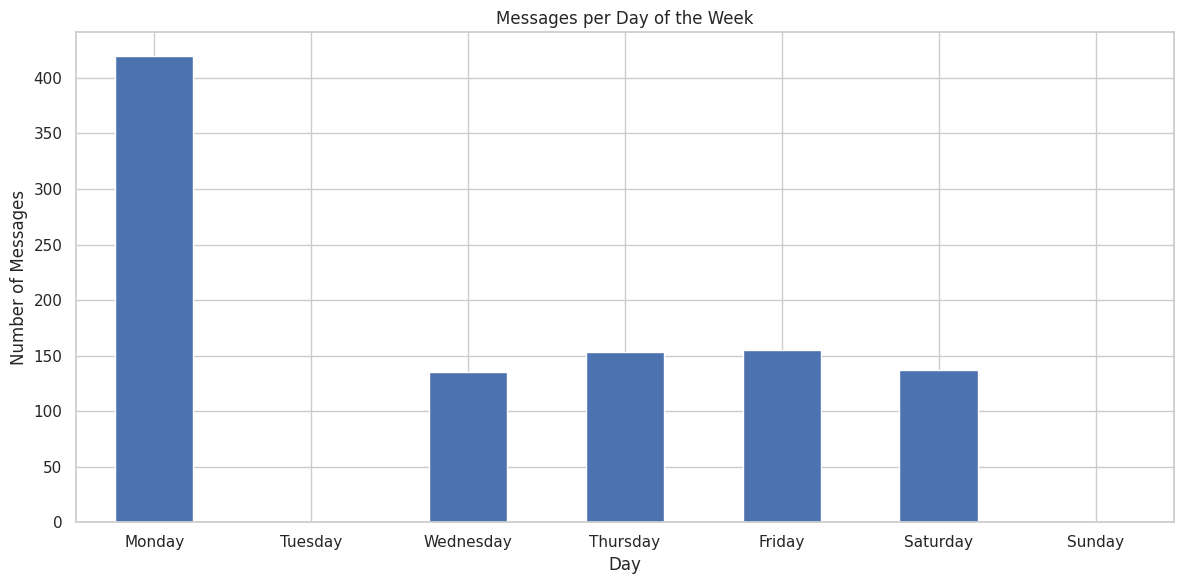

In [17]:
# Messages per day of the week
messages_per_dayname = df['DayName'].value_counts()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
messages_per_dayname = messages_per_dayname.reindex(days_order)
plt.figure(figsize=(12, 6))
messages_per_dayname.plot(kind='bar')
plt.title('Messages per Day of the Week')
plt.xlabel('Day')
plt.ylabel('Number of Messages')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

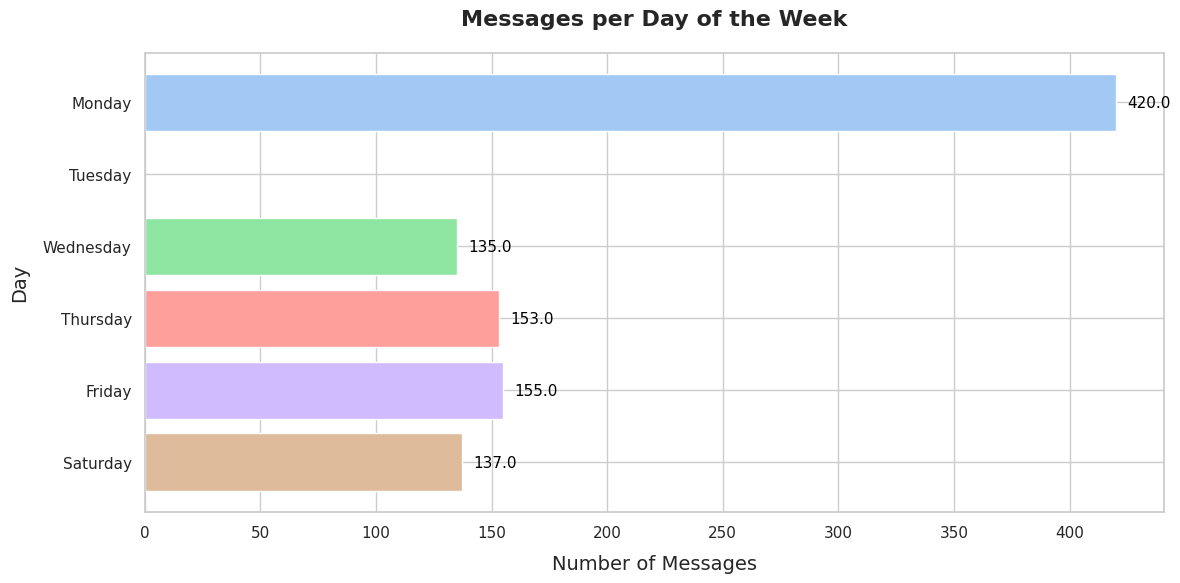

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Messages per day of the week
messages_per_dayname = df['DayName'].value_counts()

# Reorder the data to match the days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
messages_per_dayname = messages_per_dayname.reindex(days_order)

# Set the style for the plot
sns.set_theme(style="whitegrid")

# Create a horizontal bar plot
plt.figure(figsize=(12, 6))
colors = sns.color_palette("pastel", len(messages_per_dayname))
bars = plt.barh(messages_per_dayname.index, messages_per_dayname.values, color=colors)

# Add titles and labels
plt.title('Messages per Day of the Week', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Number of Messages', fontsize=14, labelpad=10)
plt.ylabel('Day', fontsize=14, labelpad=10)

# Annotate the bars with exact counts
for bar, count in zip(bars, messages_per_dayname.values):
    plt.text(
        bar.get_width() + 5,
        bar.get_y() + bar.get_height() / 2,
        str(count),
        ha='left',
        va='center',
        fontsize=11,
        color='black'
    )

# Invert the y-axis to start from Monday at the top
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


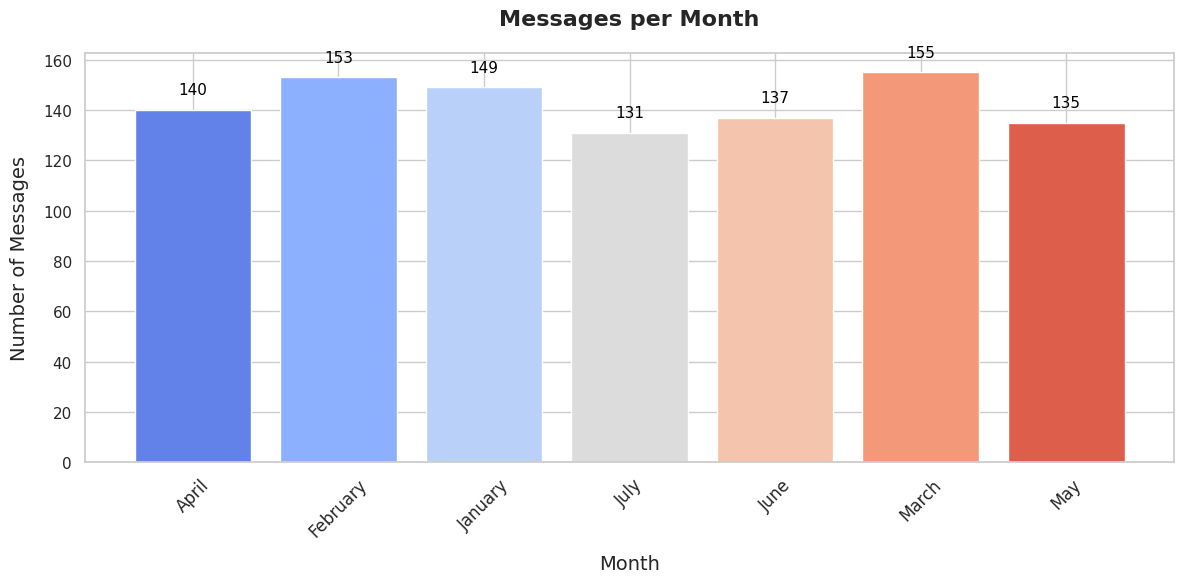

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Checking if the data spans multiple months
if df['Month'].nunique() > 1:
    # Calculate messages per month
    messages_per_month = df['Month'].value_counts().sort_index()

    # Set the style for the plot
    sns.set_theme(style="whitegrid")

    # Create the plot
    plt.figure(figsize=(12, 6))
    colors = sns.color_palette("coolwarm", len(messages_per_month))
    bars = plt.bar(messages_per_month.index, messages_per_month.values, color=colors)

    # Add titles and labels
    plt.title('Messages per Month', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Month', fontsize=14, labelpad=10)
    plt.ylabel('Number of Messages', fontsize=14, labelpad=10)

    # Annotate the bars with exact counts
    for bar, count in zip(bars, messages_per_month.values):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 5,
            str(count),
            ha='center',
            va='bottom',
            fontsize=11,
            color='black'
        )

    plt.xticks(messages_per_month.index, fontsize=12, rotation=45)
    plt.tight_layout()
    plt.show()


In [20]:
def label_message(message):
    positive_emojis = ['😊', '🥳', '👍', '😂', '😁', '😄', '😃', '🙂', '🤗']
    negative_emojis = ['😢', '😠', '🙁', '😞', '😔', '😩', '😫', '😭', '😒']
    positive_keywords = [
        'thanks', 'good', 'great', 'awesome', 'fantastic', 'happy', 'love',
        'well done', 'congratulations', 'brilliant', 'excellent', 'nice', 'lol'
    ]
    negative_keywords = [
        'sad', 'bad', 'terrible', 'hate', 'angry', 'problem', 'sorry',
        'disappointed', 'worried', 'unhappy', 'frustrated', 'nope', 'not working'
    ]

    message_lower = message.lower()
    positive_matches = any(word in message_lower for word in positive_keywords) or any(emoji in message for emoji in positive_emojis)
    negative_matches = any(word in message_lower for word in negative_keywords) or any(emoji in message for emoji in negative_emojis)

    if positive_matches and not negative_matches:
        return 'Positive'
    elif negative_matches and not positive_matches:
        return 'Negative'
    elif positive_matches and negative_matches:
        return 'Neutral'
    else:
        return 'Neutral'


In [21]:
tqdm.pandas(desc="Labeling messages")
df['Label'] = df['Message'].progress_apply(label_message)


Labeling messages: 100%|██████████| 1000/1000 [00:00<00:00, 42520.90it/s]


In [22]:
print("Label distribution:")
print(df['Label'].value_counts())


Label distribution:
Label
Neutral     759
Positive    229
Negative     12
Name: count, dtype: int64


In [23]:
le = LabelEncoder()
df['LabelEncoded'] = le.fit_transform(df['Label'])
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping:", label_mapping)


Label Mapping: {'Negative': 0, 'Neutral': 1, 'Positive': 2}


In [24]:
df.drop_duplicates(subset=['Message'], inplace=True)
df.reset_index(drop=True, inplace=True)


In [25]:
X = df['Message']
y = df['LabelEncoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [26]:
overlap = set(X_train).intersection(set(X_test))
print("Number of overlapping messages between train and test:", len(overlap))


Number of overlapping messages between train and test: 0


In [27]:
class ChatDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encoding = self.tokenizer.encode_plus(
            self.texts[idx],
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [28]:
def train_and_evaluate(model_name, train_dataset, test_dataset, num_labels):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=num_labels
    )

    training_args = TrainingArguments(
        output_dir=f'./results/{model_name}',
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,
        evaluation_strategy='epoch',
        save_strategy='epoch',
        logging_dir='./logs',
        logging_steps=10,
        load_best_model_at_end=True,
        metric_for_best_model='eval_f1',
        greater_is_better=True,
    )

    def compute_metrics(pred):
        labels = pred.label_ids
        preds = np.argmax(pred.predictions, axis=1)
        precision, recall, f1, _ = precision_recall_fscore_support(
            labels, preds, average='weighted', zero_division=0
        )
        acc = accuracy_score(labels, preds)
        return {
            'accuracy': acc,
            'f1': f1,
            'precision': precision,
            'recall': recall
        }

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer
    )

    trainer.train()
    eval_result = trainer.evaluate()
    return eval_result, trainer  # Return the trainer


In [29]:
model_names = [
    'bert-base-uncased',
    'distilbert-base-uncased',
    'roberta-base',
    'albert-base-v2'
]


In [30]:
results = {}
trainers = {}  # Dictionary to store trainers


In [31]:
for model_name in model_names:
    print(f"\nTraining and evaluating model: {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    train_dataset = ChatDataset(X_train, y_train, tokenizer)
    test_dataset = ChatDataset(X_test, y_test, tokenizer)

    eval_result, trainer = train_and_evaluate(
        model_name, train_dataset, test_dataset, num_labels=len(le.classes_)
    )

    results[model_name] = eval_result
    trainers[model_name] = trainer  # Store the trainer



Training and evaluating model: bert-base-uncased


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-28-a51036fecb30>:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wan

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.676400,0.451172,0.781818,0.770909,0.761364,0.781818
2,0.457400,0.335329,0.836364,0.830187,0.845811,0.836364
3,0.314200,0.293328,0.890909,0.870563,0.869091,0.890909



Training and evaluating model: distilbert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-28-a51036fecb30>:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.774600,0.454287,0.854545,0.828253,0.842940,0.854545
2,0.490000,0.358069,0.836364,0.827085,0.834026,0.836364
3,0.341500,0.324212,0.890909,0.870563,0.869091,0.890909



Training and evaluating model: roberta-base


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-28-a51036fecb30>:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.711500,0.349846,0.890909,0.870011,0.859917,0.890909
2,0.467200,0.198621,0.927273,0.913158,0.907071,0.927273
3,0.190600,0.172851,0.890909,0.880387,0.887273,0.890909



Training and evaluating model: albert-base-v2


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-28-a51036fecb30>:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.564700,0.335801,0.854545,0.828253,0.842940,0.854545
2,0.355600,0.296580,0.890909,0.870563,0.869091,0.890909
3,0.300300,0.282105,0.890909,0.870563,0.869091,0.890909


In [32]:
for model_name, metrics in results.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {metrics['eval_accuracy']:.4f}")
    print(f"F1 Score: {metrics['eval_f1']:.4f}")
    print(f"Precision: {metrics['eval_precision']:.4f}")
    print(f"Recall: {metrics['eval_recall']:.4f}")



Model: bert-base-uncased
Accuracy: 0.8909
F1 Score: 0.8706
Precision: 0.8691
Recall: 0.8909

Model: distilbert-base-uncased
Accuracy: 0.8909
F1 Score: 0.8706
Precision: 0.8691
Recall: 0.8909

Model: roberta-base
Accuracy: 0.9273
F1 Score: 0.9132
Precision: 0.9071
Recall: 0.9273

Model: albert-base-v2
Accuracy: 0.8909
F1 Score: 0.8706
Precision: 0.8691
Recall: 0.8909


In [33]:
def get_predictions(trainer, dataset):
    predictions = trainer.predict(dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    return preds


In [34]:
for model_name in model_names:
    print(f"\nQualitative Analysis for Model: {model_name}")
    trainer = trainers[model_name]  # Retrieve the trainer
    tokenizer = trainer.tokenizer
    model = trainer.model  # Use the model from the trainer
    test_dataset = ChatDataset(X_test, y_test, tokenizer)

    # Get predictions
    preds = get_predictions(trainer, test_dataset)

    X_test_list = X_test.tolist()
    y_test_list = y_test.tolist()

    misclassified = []
    for i in range(len(preds)):
        if preds[i] != y_test_list[i]:
            misclassified.append((
                X_test_list[i],
                le.inverse_transform([y_test_list[i]])[0],
                le.inverse_transform([preds[i]])[0]
            ))

    # Print some misclassified messages
    for text, true_label, pred_label in misclassified[:5]:
        print(f"\nText: {text}")
        print(f"True Label: {true_label}")
        print(f"Predicted Label: {pred_label}")


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.



Qualitative Analysis for Model: bert-base-uncased


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.



Text: Hey Alex, have you seen this about a technical challenge? It's hilarious! 😂
True Label: Positive
Predicted Label: Neutral

Text: Hey Emma, have you seen this about movie recommendations? It's hilarious! 🙂
True Label: Positive
Predicted Label: Neutral

Text: Hey Alex, have you seen this about a technical challenge? It's hilarious! 👍
True Label: Positive
Predicted Label: Neutral

Text: Hey Emma, have you seen this about an upcoming deadline? It's hilarious! 😭
True Label: Negative
Predicted Label: Neutral

Text: Hey John, have you seen this about a funny meme? It's hilarious! 😭
True Label: Negative
Predicted Label: Neutral

Qualitative Analysis for Model: distilbert-base-uncased


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.



Text: Hey Alex, have you seen this about a technical challenge? It's hilarious! 😂
True Label: Positive
Predicted Label: Neutral

Text: Hey Emma, have you seen this about movie recommendations? It's hilarious! 🙂
True Label: Positive
Predicted Label: Neutral

Text: Hey Alex, have you seen this about a technical challenge? It's hilarious! 👍
True Label: Positive
Predicted Label: Neutral

Text: Hey Emma, have you seen this about an upcoming deadline? It's hilarious! 😭
True Label: Negative
Predicted Label: Neutral

Text: Hey John, have you seen this about a funny meme? It's hilarious! 😭
True Label: Negative
Predicted Label: Neutral

Qualitative Analysis for Model: roberta-base


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.



Text: Hey John, have you seen this about weekend plans? It's hilarious! 👌
True Label: Neutral
Predicted Label: Positive

Text: Hey Emma, have you seen this about a funny meme? It's hilarious! 👌
True Label: Neutral
Predicted Label: Positive

Text: Hey Emma, have you seen this about an upcoming deadline? It's hilarious! 😭
True Label: Negative
Predicted Label: Positive

Text: Hey John, have you seen this about a funny meme? It's hilarious! 😭
True Label: Negative
Predicted Label: Positive

Qualitative Analysis for Model: albert-base-v2



Text: Hey Alex, have you seen this about a technical challenge? It's hilarious! 😂
True Label: Positive
Predicted Label: Neutral

Text: Hey Emma, have you seen this about movie recommendations? It's hilarious! 🙂
True Label: Positive
Predicted Label: Neutral

Text: Hey Alex, have you seen this about a technical challenge? It's hilarious! 👍
True Label: Positive
Predicted Label: Neutral

Text: Hey Emma, have you seen this about an upcoming deadline? It's hilarious! 😭
True Label: Negative
Predicted Label: Neutral

Text: Hey John, have you seen this about a funny meme? It's hilarious! 😭
True Label: Negative
Predicted Label: Neutral


In [35]:
metrics_df = pd.DataFrame.from_dict(results, orient='index')
metrics_df.to_csv('model_evaluation_results.csv')


In [36]:
# Find the model with the highest F1 score
best_model_name = max(results, key=lambda x: results[x]['eval_f1'])
print(f"\nBest model based on F1 score: {best_model_name}")
best_trainer = trainers[best_model_name]



Best model based on F1 score: roberta-base


In [37]:
# Save the best model and tokenizer
best_trainer.model.save_pretrained('./best_model')
best_trainer.tokenizer.save_pretrained('./best_model')


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


('./best_model/tokenizer_config.json',
 './best_model/special_tokens_map.json',
 './best_model/vocab.json',
 './best_model/merges.txt',
 './best_model/added_tokens.json',
 './best_model/tokenizer.json')

In [38]:
# Save LabelEncoder classes
np.save('label_classes.npy', le.classes_)

# Save evaluation metrics to a CSV file
metrics_df = pd.DataFrame.from_dict(results, orient='index')
metrics_df.to_csv('model_evaluation_results.csv')
